In [1]:
import os

os.chdir('../..')

import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'priority'
experiment_name = 'exp4'

data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [3]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

This experiment has 43 classes


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, Bidirectional, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  Input, Reshape
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D,MaxPool1D,AveragePooling1D
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential

In [11]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs): 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform') 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer) 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint) 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint) 
            self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint) 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W) 
        if self.bias:
            uit += self.b 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u) 
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [15]:
inputs = Input(shape=(1000,1))
x = Conv1D(filters=96, kernel_size=11, strides=4)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)

x = Conv1D(filters=256, kernel_size=5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Conv1D(filters=384, padding='same', kernel_size=5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(filters=384, padding='same', kernel_size=5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(filters=256, kernel_size=3)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)

x = AttentionWithContext()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(43, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(num_thresholds=200,
                                curve="ROC",
                                summation_method='interpolation',
                                name="AUC",
                                multi_label=True,
                                label_weights=None)]
)

In [17]:
history = model.fit(X_train_lead1, y_train, validation_data=(X_val_lead1, y_val), epochs=100)

Epoch 1/100
534/534 [==============================] - 240s 434ms/step - loss: 0.1181 - accuracy: 0.9587 - recall: 0.2701 - AUC: 0.5773 - val_loss: 0.1054 - val_accuracy: 0.9591 - val_recall: 0.2517 - val_AUC: 0.6167
Epoch 2/100
534/534 [==============================] - 208s 389ms/step - loss: 0.1062 - accuracy: 0.9600 - recall: 0.2803 - AUC: 0.6116 - val_loss: 0.0992 - val_accuracy: 0.9617 - val_recall: 0.2905 - val_AUC: 0.6290
Epoch 3/100
534/534 [==============================] - 204s 382ms/step - loss: 0.1022 - accuracy: 0.9617 - recall: 0.3001 - AUC: 0.6184 - val_loss: 0.0954 - val_accuracy: 0.9626 - val_recall: 0.3053 - val_AUC: 0.6440
Epoch 4/100
534/534 [==============================] - 204s 381ms/step - loss: 0.0992 - accuracy: 0.9623 - recall: 0.3097 - AUC: 0.6264 - val_loss: 0.0968 - val_accuracy: 0.9609 - val_recall: 0.2680 - val_AUC: 0.6502
Epoch 5/100
534/534 [==============================] - 200s 374ms/step - loss: 0.0978 - accuracy: 0.9625 - recall: 0.3144 - AUC: 0.6

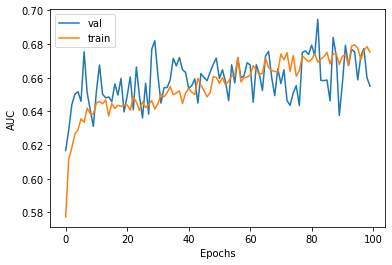

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_AUC'],label='val')
plt.plot(history.history['AUC'],label='train')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

In [19]:
from sklearn.metrics import roc_auc_score

preds = model.predict(X_train_lead1)

roc_auc_score(y_train,preds)

534/534 [==============================] - 46s 84ms/step


0.856443706524591

In [20]:
from sklearn.metrics import roc_auc_score

preds = model.predict(X_test_lead1)

roc_auc_score(y_test,preds)

68/68 [==============================] - 7s 96ms/step


0.8027187783693546

In [21]:
preds = model.predict(X_val_lead1)

roc_auc_score(y_val,preds)

67/67 [==============================] - 3s 43ms/step


0.7971845135925308

In [22]:
import numpy as np
y = np.concatenate([y_train,y_val, y_test])
X = np.concatenate([X_train_lead1, X_val_lead1,X_test_lead1])

preds = model.predict(X)

roc_auc_score(y,preds)

668/668 [==============================] - 57s 85ms/step


0.8451306213611584

In [23]:
model = Sequential()
model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(1000,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(filters=256, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(filters=384, padding='same', kernel_size=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(filters=384, padding='same', kernel_size=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(filters=256, kernel_size=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))
model.add(GlobalAveragePooling1D())
model.add(AttentionWithContext())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(43, activation='sigmoid'))

AssertionError: 